# Calculate Gene mC Fractions

In [1]:
import pandas as pd
import scanpy as sc
import anndata
import xarray as xr
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import pathlib
import numpy as np

In [2]:
gene_meta_path = '../../data/genome/gencode.vM22.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM']

# change this to the path to your filtered metadata
metadata_path = '../step_by_step/100kb/CellMetadata.PassQC.csv.gz'

# change this to the paths to your MCDS files
mcds_path = '../../data/Brain/snmC-seq2/Liu2021Nature.mcds/',
obs_dim = 'cell'
var_dim = 'geneslop2k'

min_cov = 5


## Load metadata

In [3]:
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 16985 cells


## Filter genes by overlap and chromosomes

In [5]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

41871 features remained


## Filter genes by cell mean coverage

Feature geneslop2k mean cov across cells added in MCDS.coords['geneslop2k_cov_mean'].


/tmp/ipykernel_166231/2001998121.py:7: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  use_features &= feature_cov_mean[feature_cov_mean > min_cov].index


40331 features remained


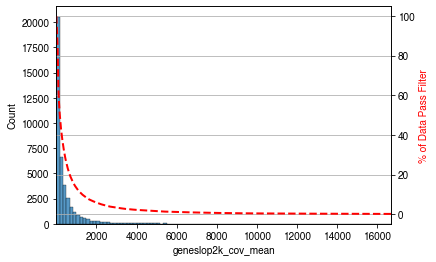

In [6]:
mcds = MCDS.open(mcds_path, 
                 var_dim=var_dim,
                 use_obs=metadata.index).sel({var_dim: use_features})
mcds.add_feature_cov_mean()

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

In [7]:
mcds.filter_feature_by_cov_mean(min_cov=min_cov)

Before cov mean filter: 41871 geneslop2k
 After cov mean filter: 40331 geneslop2k 96.3%


<xarray.MCDS>
Dimensions:              (cell: 16985, count_type: 2, geneslop2k: 40331, mc_type: 2)
Coordinates:
  * cell                 (cell) <U10 '10E_M_207' '10E_M_338' ... '9J_M_2969'
  * count_type           (count_type) <U3 'mc' 'cov'
  * geneslop2k           (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSM...
    geneslop2k_chrom     (geneslop2k) <U5 dask.array<chunksize=(40331,), meta=np.ndarray>
    geneslop2k_end       (geneslop2k) int64 dask.array<chunksize=(40331,), meta=np.ndarray>
    geneslop2k_start     (geneslop2k) int64 dask.array<chunksize=(40331,), meta=np.ndarray>
  * mc_type              (mc_type) <U3 'CGN' 'CHN'
    strand_type          <U4 'both'
    geneslop2k_cov_mean  (geneslop2k) float64 74.71 58.61 ... 40.27 1.367e+03
Data variables:
    geneslop2k_da        (cell, geneslop2k, mc_type, count_type) uint16 dask.array<chunksize=(3397, 2776, 2, 2), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  geneslop2k

## Calculate and Save Gene mC Fractions

In [8]:
mcds.add_mc_frac(normalize_per_cell=True, clip_norm_value=10)

In [10]:
# only keep fraction for saving
mcds = mcds[['geneslop2k_da_frac']]
mcds['geneslop2k_da_frac'] = mcds['geneslop2k_da_frac'].astype('float32')

In [14]:
mcds.write_dataset('geneslop2k_frac.mcds', var_dims=['geneslop2k'])

/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


PosixPath('geneslop2k_frac.mcds')

## Save gene metadata together with gene fraction files

In [16]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv('GeneMetadata.csv.gz')